In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import lime
import lime.lime_tabular

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from notebooks.data_generation import generate_challenge_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
n_useless_features = 1
x, y = generate_challenge_dataset(n_useless_features)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", acc_train)

y_pred_test = clf.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", acc_test)

Train Accuracy: 0.979375
Test Accuracy: 0.8525


In [19]:
explain_index = 200
num_features = x_train.shape[1]
feature_names = [str(idx) for idx in range(1, num_features + 1)]

In [20]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train,
    mode="classification",
    feature_names=feature_names,
    class_names=["y=0", "y=1"],
    verbose=False,
    discretize_continuous=False,
)

In [ ]:
# This will not work right away
# explanation = explainer.explain_instance(
#     x_test[explain_index],
#     clf.predict,
#     num_features=num_features,
# )

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

In [22]:
predict_probability = lambda x: clf.predict_proba(x).astype(float)
explanation = explainer.explain_instance(
    x_test[explain_index],
    predict_probability,
    num_features=num_features,
)

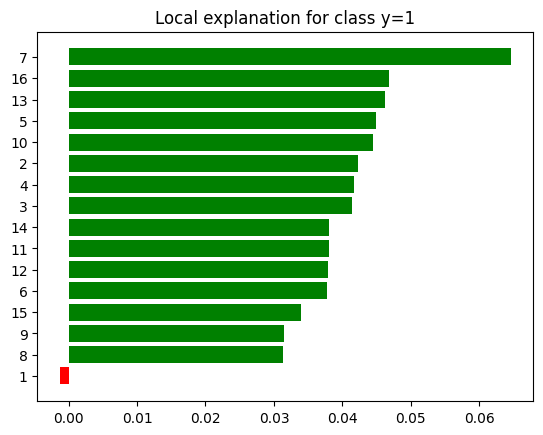

In [23]:
%matplotlib inline
fig = explanation.as_pyplot_figure()

In [24]:
print(explanation)

In [25]:
def print_attributes(my_object):
    print(
        "\n".join(
            [
                attribute
                for attribute in dir(my_object)
                if not attribute.startswith("_")
            ]
        )
    )

In [26]:
print_attributes(explanation)

as_html
as_list
as_map
as_pyplot_figure
available_labels
class_names
domain_mapper
intercept
local_exp
local_pred
mode
predict_proba
random_state
save_to_file
score
show_in_notebook
top_labels


In [27]:
print(explanation.local_exp)
print(explanation.as_list())

{1: [(np.int64(6), np.float64(0.06461344011508507)), (np.int64(15), np.float64(0.046750780263410924)), (np.int64(12), np.float64(0.04616795604693405)), (np.int64(4), np.float64(0.04490926062487185)), (np.int64(9), np.float64(0.04439491345970839)), (np.int64(1), np.float64(0.04227262117964739)), (np.int64(3), np.float64(0.04166274511842196)), (np.int64(2), np.float64(0.041457330608045344)), (np.int64(13), np.float64(0.03810275595086199)), (np.int64(10), np.float64(0.0380134962609689)), (np.int64(11), np.float64(0.03791866957658282)), (np.int64(5), np.float64(0.037745353198070826)), (np.int64(14), np.float64(0.03388620497127191)), (np.int64(8), np.float64(0.03143689223127604)), (np.int64(7), np.float64(0.03125888823934607)), (np.int64(0), np.float64(-0.0012492170034635367))]}
[('7', 0.06461344011508507), ('16', 0.046750780263410924), ('13', 0.04616795604693405), ('5', 0.04490926062487185), ('10', 0.04439491345970839), ('2', 0.04227262117964739), ('4', 0.04166274511842196), ('3', 0.041457

In [28]:
avg_useful_lime_importances_list = []
useless_feature_lime_importances_list = []

first_useful_feature = 2

useless_feature = 1
useful_features = np.arange(first_useful_feature, num_features - 1)

for idx in range(len(x_test)):
    explanation = explainer.explain_instance(
        x_test[idx],
        predict_probability,
        num_features=num_features,
    )
    explanation_dictionary = {
        feature: value for feature, value in explanation.as_list()
    }
    lime_importances = np.array(explanation.as_list(), dtype=np.float32)
    useless_feature_lime_importance = lime_importances[
        lime_importances[:, 0] == useless_feature
    ][:, 1]
    useful_lime_importances = lime_importances[
        np.isin(lime_importances[:, 0], list(useful_features))
    ][:, 1]
    avg_useful_lime_importance = np.average(useful_lime_importances)
    avg_useful_lime_importances_list.append(avg_useful_lime_importance)
    useless_feature_lime_importances_list.append(
        useless_feature_lime_importance
    )

In [29]:
useless_feature_lime_importances = np.array(
    useless_feature_lime_importances_list
)
avg_useful_lime_importances = np.array(avg_useful_lime_importances_list)

In [30]:
max_useless_to_useful_importance_ratio = np.max(
    useless_feature_lime_importances / avg_useful_lime_importances
)

In [31]:
print(max_useless_to_useful_importance_ratio)

0.094614275


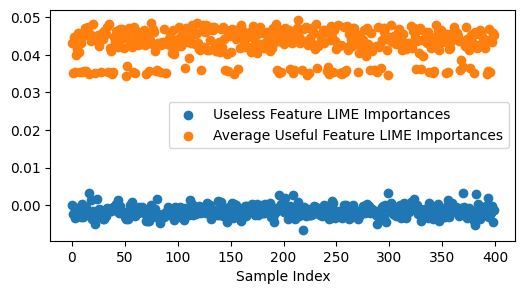

In [32]:
indices = np.arange(len(useless_feature_lime_importances))

plt.figure(figsize=(6, 3))
plt.scatter(
    indices,
    useless_feature_lime_importances,
    label="Useless Feature LIME Importances",
)
plt.scatter(
    indices,
    avg_useful_lime_importances,
    label="Average Useful Feature LIME Importances",
)
plt.xlabel("Sample Index")
plt.legend()